In [2]:
import numpy as np
import pandas as pd
import math as m
import sympy as sym
import random as rand
import matplotlib.pyplot as plt
import cmath as cm
from IPython.display import display, Latex

In [3]:
# defininsg coefficeients sybols

def Creating_states( coeff = [1/(2**.5),1/(2**.5),1/(2**.5),1/(2**.5)] , Abstract = False):    # coeff list like [a0,a1,b0,b1]
    if Abstract == True:
        a0 = sym.symbols('a0')
        a1 = sym.symbols('a1')
        b0 = sym.symbols('b0')
        b1 = sym.symbols('b1')
    else:
        a0 = coeff[0]
        a1 = coeff[1]
        b0 = coeff[2]
        b1 = coeff[3]
    psi0 = [a0,a1]      # defining states
    psi1 = [b0,b1]
    return([psi0,psi1])


initial_states = Creating_states(Abstract=False, coeff = [1/(2**.5),1/(2**.5),1,0])     # Creating the two states with these coefficients

psi0 = initial_states[0]
psi1 = initial_states[1]

psi0sq = []
psi1sq = []
[[psi0sq.append(i*j) for i in psi0] for j in psi0]
[[psi1sq.append(i*j) for i in psi1] for j in psi1]   # creating list of coeff for squared states (intermeditate step)

psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]        # the second element is the normalized coefficient due to the addition of states (01+10). See OneNote writeup for details
psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]            # symmetric states in basis (|00>, normalized version of (|01>+|10>),|11>)

# psi0psi0
# sum([i**2 for i in psi0psi0])   # adding to 1

In [4]:
# Creating Theoretical density matrix

vec_psi0psi0 = np.array(psi0psi0)     # convertying to numpy arrays
vec_psi1psi1 = np.array(psi1psi1)

rho = (1/2)*(np.outer(vec_psi0psi0, vec_psi0psi0)+np.outer(vec_psi1psi1, vec_psi1psi1))       # density matrix with priors 1/2 each.

print(' Rho matrix : \n' ,rho)

 Rho matrix : 
 [[0.625     0.1767767 0.125    ]
 [0.1767767 0.25      0.1767767]
 [0.125     0.1767767 0.125    ]]


In [5]:
# creating the SIC POVM matrices
w = m.e**((2/3)*m.pi*(1j))     # the w in the notes
POVM_vec = (1/(2**.5))*(np.array([[0,1,-1],[-1,0,1],[1,-1,0],[0,w,-w**2],[-1,0,w**2],[1,-w,0],[0,w**2,-w],[-1,0,w],[1,-w**2,0]]))  # an array of POVM direction vectors
POVM_elts = [(1/3)*np.outer(np.conjugate(POVM_vec[i]),POVM_vec[i]) for i in range(len(POVM_vec))]   # a list of POVM matrices

# sum([np.trace(POVM_elts[i]) for i in range(9)])     # trace sum = 3 = Tr(Identity_(3X3)) , verified   

prob_vec_raw =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)]  #[(POVM_elts[i]*rho).trace() for i in range(len(POVM_elts))]
prob_vec = [i.real for i in prob_vec_raw if abs(i.imag) < .01]          # cleaned up the trailing imaginary parts

sum(prob_vec)        # sum prob = 1, verified

0.9999999999999994

In [6]:
#Experimental part

N = 10000       # number of measurements  

POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']       # symbols to indicate collapsed direction
#prob distribution is simply the corresponding elements of the prob_vec
collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   #choosing collapse directions with weights for N trials

nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
pj_num_vec = [i/N for i in nj_vec]      

# ([i*N for i in prob_vec] , nj_vec)   # comparing the theoretical and experimental collapse probabilities, verified


In [7]:
# finding r vector
M = [[np.trace(np.dot(POVM_elts[i],POVM_elts[j])) for i in range(len(POVM_elts))] for j in range(len(POVM_elts))]     # creating M matrix using POVM definition

u_0 = [1/3 for i in range(9)]           # cerating u_0 vector, to create the inverse matrix
M_inv = 3*np.outer(u_0,u_0) + 12*(np.eye(9) - np.outer(u_0,u_0))        # creating the inverse matrix
# np.trace(np.dot(M,M_inv))       # gives identity, checks out
r_vec = np.dot(M_inv,pj_num_vec)


In [8]:
#Reconstructing numerical rho
rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in notes pair_disc.pdf

rho_num = np.zeros_like(rho_num_list[0])

# Loop over the matrices and sum them element-wise to find the numerically reconstructed rho
for matrix in rho_num_list:
    rho_num = np.add(rho_num, matrix)

print('Numerical rho:\n', rho_num)   

Numerical rho:
 [[0.6248+0.00000000e+00j 0.1702-7.96743371e-03j 0.1253+3.29089653e-03j]
 [0.1702+7.96743371e-03j 0.2562+3.32310765e-18j 0.178 +6.58179307e-03j]
 [0.1253-3.29089653e-03j 0.178 -6.58179307e-03j 0.119 +2.35643136e-18j]]


In [9]:
#Error Stuff   
del_rho = rho_num-rho  # defining the difference of numberical and theoretical state
# del_rho

eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
# eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue

# norm_del_rho    # "error in the density matrices"

Pretty much everything above combined into a function for the sake of ease

In [66]:
#Creating function for the sake of ease, for the error in the density matrices. This plots 
def experiment_rho(N = 10000, coeff = [1,0,0,1], priors = [.5,.5], show_calcs = False):
    initial_states = Creating_states(Abstract=False, coeff = coeff)     # Creating the two states with these coefficients
    psi0 = initial_states[0]
    psi1 = initial_states[1]    # created the states to be discriminated

    psi0sq = []
    psi1sq = []
    [[psi0sq.append(i*j) for i in psi0] for j in psi0]
    [[psi1sq.append(i*j) for i in psi1] for j in psi1]   
    psi0psi0 = [psi0sq[0], (psi0sq[1]**2+psi0sq[2]**2)**(.5), psi0sq[3]]    
    psi1psi1 = [psi1sq[0], (psi1sq[1]**(2)+psi1sq[2]**(2))**(.5), psi1sq[3]]    # creating square states
    
    vec_psi0psi0 = np.array(psi0psi0)     
    vec_psi1psi1 = np.array(psi1psi1)
    rho = priors[0]*np.outer(vec_psi0psi0, vec_psi0psi0)+ priors[1]*np.outer(vec_psi1psi1, vec_psi1psi1)     # theoretical density matrix with priors 1/2 each.

    prob_vec =  [np.trace(np.dot(POVM_elts[i],rho)) for i in range(9)] 
    prob_vec = [round(i.real, 5) for i in prob_vec if abs(i.imag) < .01]          # cleaned up theoretical prob vector

    POVM_dir_symbols = ['d1','d2','d3','d4','d5','d6','d7','d8','d9']      # symbols to indicate collapsed direction
    #prob distribution is simply the corresponding elements of the prob_vec
    collapse_dir_vec = rand.choices(POVM_dir_symbols, weights=prob_vec, k = N)   # choosing collapse directions with weights for N trials

    nj_vec = [collapse_dir_vec.count(f'd{i+1}') for i in range(9)]
    pj_num_vec = [i/N for i in nj_vec]                                  # numerical prob vector     
    
    r_vec = np.dot(M_inv,pj_num_vec)
    
    # constructing the rho numrical using the r_vector etc.
    rho_num_list = [r_vec[i]*POVM_elts[i] for i in range(len(POVM_elts))]   # list of matrices, see equation 7 in Hillery notes pair_disc.pdf
    rho_num_raw = np.zeros_like(rho_num_list[0])
    for matrix in rho_num_list:
        rho_num_raw = np.add(rho_num_raw, matrix)       # created the numerical rho
    
    rho_num = np.real_if_close(np.around(rho_num_raw, decimals=5))
    del_rho = rho_num-rho 
    
    eigenvalues, eigenvectors = np.linalg.eig(del_rho)  # each COLUMN is the corresponding eigenvector and not the row. eigenvectors[:,0]
    # eigenvectors[:,0]   # eigenvector correspoding to the first eigenvalue
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])    # cleaning up
    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))

    norm_del_rho = max([abs(i) for i in evals])     # picking out the largest magnitude evalue
    error = norm_del_rho

    if show_calcs == True:
        # Display states in LateX
        latex_psi0 = r'\Psi_0 = {}|0\rangle + {}|1\rangle'.format(psi0[0],psi0[1])
        latex_psi1 = r'\Psi_1 = {}|0\rangle + {}|1\rangle'.format(psi1[0],psi1[1])
        display(Latex(f'${latex_psi0}$'))
        display(Latex(f'${latex_psi1}$'))

        # Printing other parameters
        print('\n Rho_Theorectical = \n', rho)

        print('\n Prob_theory = ', prob_vec)
        print('Prob_numerical = ', pj_num_vec)

        print('Rho_Numerical_raw = \n', rho_num_raw )
        print('\n Rho_Numerical = \n', rho_num )
        
        print('\nDifference (rho-rho_num) = \n ', del_rho )
        
        print('\n evals of del_rho= \n ', evals)
        print('\n evecs of del_rho= \n ', evecs)
        
        spectral_reconstruction_DelRho = evals[0]*np.outer(evecs[:,0], evecs[:,0])+evals[1]*np.outer(evecs[:,1], evecs[:,1])+evals[2]*np.outer(evecs[:,2], evecs[:,2])  # verifying spectral decomposition, and that indeed the columns r the evecs
        print('Spectra_reconstruction = \n',spectral_reconstruction_DelRho)
        
        print('\n largest mod eval (error) =' , error)
    return [error, rho, rho_num, evals, evecs]

experiment_rho(10000, [1,0,0,1],[.5,.5], True)     # Example. prints intermediate quantites for analysis.


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>


 Rho_Theorectical = 
 [[0.5 0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.5]]

 Prob_theory =  [0.08333, 0.16667, 0.08333, 0.08333, 0.16667, 0.08333, 0.08333, 0.16667, 0.08333]
Prob_numerical =  [0.0782, 0.1716, 0.079, 0.0894, 0.1634, 0.0838, 0.0832, 0.1662, 0.0852]
Rho_Numerical_raw = 
 [[ 0.4984+0.00000000e+00j  0.011 +2.42487113e-03j -0.0136-4.84974226e-03j]
 [ 0.011 -2.42487113e-03j -0.0024+2.59156159e-19j  0.0162-1.07387150e-02j]
 [-0.0136+4.84974226e-03j  0.0162+1.07387150e-02j  0.504 +2.68052827e-18j]]

 Rho_Numerical = 
 [[ 0.4984+0.j       0.011 +0.00242j -0.0136-0.00485j]
 [ 0.011 -0.00242j -0.0024+0.j       0.0162-0.01074j]
 [-0.0136+0.00485j  0.0162+0.01074j  0.504 +0.j     ]]

Difference (rho-rho_num) = 
  [[-0.0016+0.j       0.011 +0.00242j -0.0136-0.00485j]
 [ 0.011 -0.00242j -0.0024+0.j       0.0162-0.01074j]
 [-0.0136+0.00485j  0.0162+0.01074j  0.004 +0.j     ]]

 evals of del_rho= 
  [-0.02944637  0.00606466  0.02338171]

 evecs of del_rho= 
  [[-0.46 -0.262j  0.765+0.j    -0.

[0.029446368811340273,
 array([[0.5, 0. , 0. ],
        [0. , 0. , 0. ],
        [0. , 0. , 0.5]]),
 array([[ 0.4984+0.j     ,  0.011 +0.00242j, -0.0136-0.00485j],
        [ 0.011 -0.00242j, -0.0024+0.j     ,  0.0162-0.01074j],
        [-0.0136+0.00485j,  0.0162+0.01074j,  0.504 +0.j     ]]),
 array([-0.02944637,  0.00606466,  0.02338171]),
 array([[-0.46 -0.262j,  0.765+0.j   , -0.213-0.297j],
        [ 0.621+0.j   ,  0.309-0.467j,  0.354-0.42j ],
        [-0.526-0.239j, -0.189-0.255j,  0.752+0.j   ]])]

The cell below has example how eigenvectors change drastically for different trials with the exact same initial parameters. Is it coz
these are evectors of the difference matrix - and this fluctuates randomly bw negative/positive for each entry - thus making evectors of this 
matrix quite sensitve to random fluctuations.

In [13]:
# prinintng evector matrix of the difference matrix delta rho.

print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])
print('\n\n')
print(experiment_rho(100000,[1,0,0,1])[2])





[[-0.542+0.047j  0.691+0.j    -0.1  -0.465j]
 [ 0.21 -0.064j  0.279-0.546j  0.759+0.j   ]
 [ 0.81 +0.j     0.347+0.16j  -0.237-0.377j]]



[[-0.138+0.351j  0.787+0.j    -0.42 +0.25j ]
 [ 0.025-0.529j  0.57 +0.114j  0.617+0.j   ]
 [ 0.759+0.j     0.204-0.037j -0.212-0.579j]]



[[ 0.237-0.463j  0.8  +0.j    -0.282+0.093j]
 [ 0.642+0.j    -0.391-0.378j -0.517+0.154j]
 [ 0.562-0.012j  0.104-0.23j   0.788+0.j   ]]



[[ 0.729+0.j     0.351-0.524j -0.232+0.132j]
 [-0.332-0.445j  0.77 +0.j     0.239+0.204j]
 [ 0.372+0.147j -0.037+0.09j   0.911+0.j   ]]



[[ 0.776+0.j     0.464+0.085j -0.415+0.047j]
 [ 0.034+0.115j  0.63 +0.j     0.767+0.j   ]
 [-0.599+0.156j  0.594-0.166j -0.485+0.04j ]]



[[ 0.842+0.j    -0.391+0.323j  0.08 -0.165j]
 [ 0.216+0.09j   0.617+0.j     0.751+0.j   ]
 [ 0.327+0.36j   0.601-0.001j -0.631-0.064j]]



[[ 0.603-0.129j  0.711+0.j    -0.336-0.037j]
 [ 0.765+0.j    -0.441-0.159j  0.441+0.004j]
 [-0.168-0.075j  0.522+0.051j  0.831+0.j   ]]



[[ 0.55 +0.31j   0.744+0

In [182]:
# defining solving the quadratic equation fn
def solve_quadratic(a, b, c):
    d = (b**2) - (4*a*c)
    sol1 = (-b-np.sqrt(d))/(2*a)
    sol2 = (-b+np.sqrt(d))/(2*a)
    return [sol1, sol2]

In [173]:
"""

def fid( N = 1000,c = [1,0,0,1], p = [.5,.5]):
    rho = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[1]
    rho_expt = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[2]
    eigenvalues, eigenvectors = np.linalg.eig(rho_expt) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))
    min_eval = np.min([abs(i) for i in evals])
    xi = evecs[:, np.argmin([abs(i) for i in evals])]     # xi vector is same as the vector corresponding to the minimum eval
    c00,c01,c11 = xi[0],xi[1],xi[2]
    z_a,z_b =solve_quadratic(c00, 2*c01, c11)[0], solve_quadratic(c00, 2*c01, c11)[1]
    a0,a1 = (abs(z_a)/(np.sqrt(1+abs(z_a)**2))), (1/(np.sqrt(1+abs(z_a)**2)))
    b0,b1 = (abs(z_b)/(np.sqrt(1+abs(z_b)**2))), (1/(np.sqrt(1+abs(z_b)**2)))
    c_num = [a0,a1,b0,b1]
    F_a = sum([c[i]*c_num[i] for i in range(2)])
    F_b = sum([c[i]*c_num[i] for i in range(2,4)])
    return [[xi], [z_a,z_b], c, c_num, [F_a,F_b]]

"""

In [393]:
def fid( N = 1000,c = [1,0,0,1], p = [.5,.5]):
    rho = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[1]
    rho_expt = experiment_rho(N= N, coeff=c, priors= p, show_calcs= False)[2]
    eigenvalues, eigenvectors = np.linalg.eig(rho_expt) 
    evals = np.array([i.real for i in eigenvalues if abs(i.imag)< .001])
    evecs = np.real_if_close(np.around(eigenvectors, decimals=3))
    min_eval = np.min([abs(i) for i in evals])
    xi = evecs[:, np.argmin([abs(i) for i in evals])]     # xi vector is same as the vector corresponding to the minimum eval
    c00,c01,c11 = xi[0],xi[1],xi[2]
    
    # z_a,z_b =solve_quadratic(c00, 2*c01, c11)[0], solve_quadratic(c00, 2*c01, c11)[1]
    
    if abs(c00) > .05 and abs(c11) > .05:
        z_a,z_b =solve_quadratic(c00, 2*c01, c11)[0], solve_quadratic(c00, 2*c01, c11)[1]
        a0,a1 = (abs(z_a)/(np.sqrt(1+abs(z_a)**2))), (1/(np.sqrt(1+abs(z_a)**2)))
        b0,b1 = (abs(z_b)/(np.sqrt(1+abs(z_b)**2))), (1/(np.sqrt(1+abs(z_b)**2)))
    elif abs(c00) < .05 and abs(c11) > .05:
        a0, a1 = 1,0        # random choice, matching later
        z = (-c11)/(2*c01)
        b0, b1 = (abs(z)/(np.sqrt(1+abs(z)**2))), (1/(np.sqrt(1+abs(z)**2)))
    elif abs(c00) > .05 and abs(c11) < .05:
        a0, a1 = 0,1        
        z = (-2*c01)/(c00)
        b0, b1 = (abs(z)/(np.sqrt(1+abs(z)**2))), (1/(np.sqrt(1+abs(z)**2)))
    elif abs(c00) < .05 and abs(c11) < .05:
        a0, a1 = 0,1        
        b0, b1 = 1,0     

    c_raw = [a0,a1,b0,b1]
    c_raw = [round(i,4) for i in c_raw]

    theta_00 = np.arccos((c_raw[0]*c[0]+c_raw[1]*c[1]))
    theta_11 = np.arccos((c_raw[2]*c[2]+c_raw[3]*c[3]))

    if abs(theta_00) < abs(theta_11):
        c_num = c_raw
    else:
        c_num = [c_raw[2],c_raw[3],c_raw[0],c_raw[1]]


    F_a = (sum([c[i]*c_num[i] for i in range(2)]))**2
    F_b = (sum([c[i]*c_num[i] for i in range(2,4)]))**2


    print('theta', [theta_00,theta_11])
    print('xi', xi)
    print('\n \n')
    print('Fidelity', [F_a,F_b])
    print('Theoretical', c)
    print('Numeriacl', c_num)

    # return [[xi], '', c , c_num, [F_a,F_b]]



In [394]:
#new
c0s = [1,0,0,1]
c0 = [0,1,1,0]
c1 = [.707,.707,0,1]
c2 = [-.707,.707,0,1]
c3 = [-1,0,.707,.707]
c4 = [(2**.5)/(3**.5),1/(3**.5),.707,.707]         
c5 = [1,0,1,0]   # same states   


fid(c=c0)


theta [0.0, 0.03464274843605503]
xi [0.046-0.051j 0.997+0.j    0.021+0.04j ]

 

Fidelity [1, 0.9988003599999999]
Theoretical [0, 1, 1, 0]
Numeriacl [0, 1, 0.9994, 0.0344]


In [331]:
# orig
c0s = [1,0,0,1]
c0 = [0,1,1,0]
c1 = [.707,.707,0,1]
c2 = [-.707,.707,0,1]
c3 = [-1,0,.707,.707]
c4 = [(2**.5)/(3**.5),1/(3**.5),.707,.707]         
c5 = [1,0,1,0]   # same states   


fid(c=c5)

# print(list(range(2)))

[[array([ 0.015-0.033j, -0.064+0.053j,  0.996+0.j   ])],
 [(4.733877245513153-2.904747804548503j),
  (-0.6105895742802766+4.909314014594165j)],
 [1, 0, 1, 0],
 [0.9841747911561697,
  0.17720039631081416,
  0.9801757859739649,
  0.19812982761391593],
 [0.9686000195472902, 0.96074457140968]]

Q: What about the complex entries in the evectors of rho? How does the equation adjust to accomodate that?

In [179]:
# Plotting function for both quantities

def Plotting(N = 10000, c = [1,0,0,1], p = [.5,.5], step = 100, metric = 'f', size = [3,3]):        # function to plot error vs trials plot. N,c,p are Number of trials, coefficients and priors
    count = N//step
    trials_list = [step*(i+1) for i in range(count)]    # only works if N is a multiple of 100
    sqrtN = [2.6/((i+1)**.5) for i in trials_list]    #ideal square root shape with a constant multiplied for scaling
    
    if metric == 'f':
        label_0 = r' Fidelity $| \Psi_0 \rangle $'
        label_1 = r' Fidelity $| \Psi_1\rangle$'
        errors_list_0 = [fid(i,c,p)[-1][0] for i in trials_list]
        errors_list_1 = [fid(i,c,p)[-1][1] for i in trials_list]
        convergance = f'Error Coverged to:  , {fid(N, c, p)[-1]}'
    else: 
        label_0 = r'$\Delta \rho$'
        errors_list_0 = [experiment_rho(i, c , p)[0] for i in trials_list]
        convergance = f'Error Coverged to:  , {experiment_rho(N, c, p)}'

    plt.figure(figsize=(size[0],size[1]))
    plt.xlabel(f' {N} (trials)')
    plt.ylabel(r'|\Delta \rho|')

    plt.plot(trials_list, errors_list_0, label=label_0)
    if metric=='f':
        plt.plot(trials_list, errors_list_1, label=label_1)
        plt.ylabel('Fidelity')
    else:
        plt.plot(trials_list,sqrtN, "--", label=r'$\frac{1}{\sqrt{N}}$')
    plt.title(r'$|\psi_0\rangle ={}|0\rangle+{}|1\rangle $, $|\psi_1\rangle ={}|0\rangle+{}|1\rangle $, $\eta_1={},\,\eta_2={}$'.format(round(c[0],3), round(c[1],3), round(c[2],3), round(c[3],3), p[0], p[1]))
    plt.legend()
    plt.show()
    
    print(convergance)



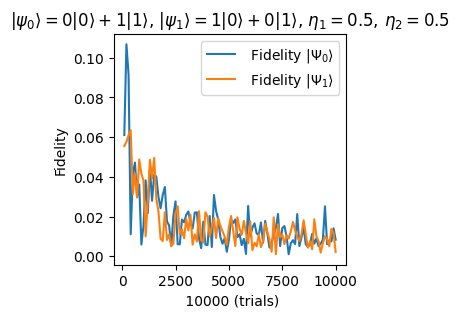

Error Coverged to:  , [0.011628693101605836, 0.004949591537698787]


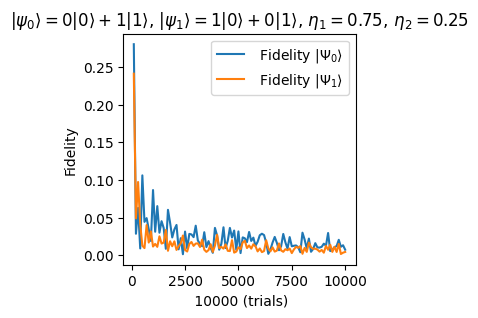

Error Coverged to:  , [0.0015015122200718969, 0.016461252904815496]


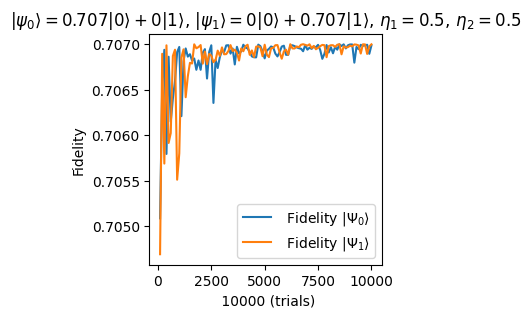

Error Coverged to:  , [0.7069920462649341, 0.7069849765035595]


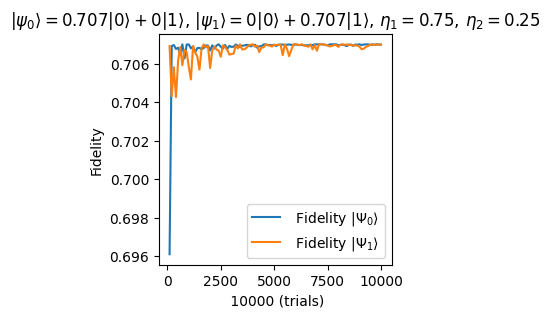

Error Coverged to:  , [0.7069924718335342, 0.7068494823464601]


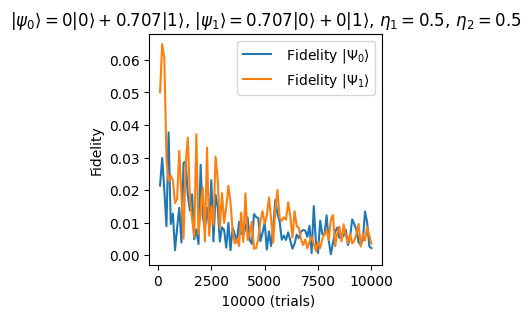

Error Coverged to:  , [0.005146983630033335, 0.005098198503307747]


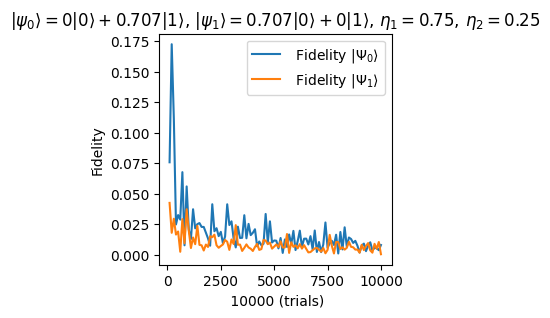

Error Coverged to:  , [0.014521975921491055, 0.003956084884040886]


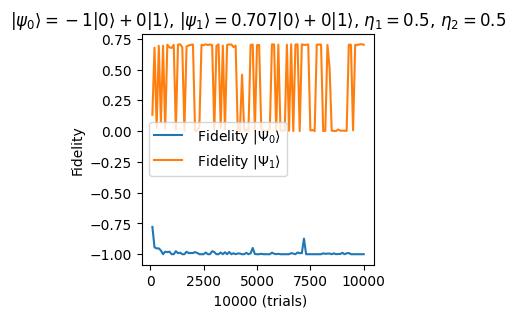

Error Coverged to:  , [-0.9952112665765389, 0.7043037988558827]


/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/4215831646.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  sol1 = (-b-np.sqrt(d))/(2*a)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/4215831646.py:4: RuntimeWarning: invalid value encountered in scalar divide
  sol1 = (-b-np.sqrt(d))/(2*a)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/4215831646.py:5: RuntimeWarning: invalid value encountered in scalar divide
  sol2 = (-b+np.sqrt(d))/(2*a)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/598383882.py:11: RuntimeWarning: invalid value encountered in scalar divide
  a0,a1 = (abs(z_a)/(np.sqrt(1+abs(z_a)**2))), (1/(np.sqrt(1+abs(z_a)**2)))


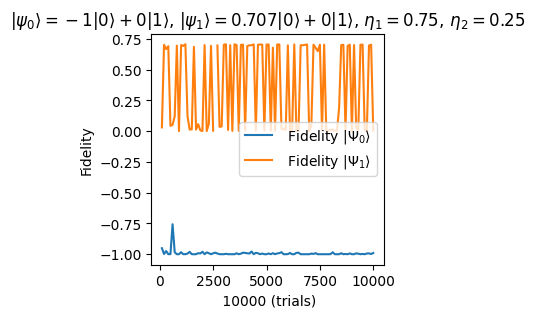

Error Coverged to:  , [-0.9999695040178043, 0.0041373626693206825]


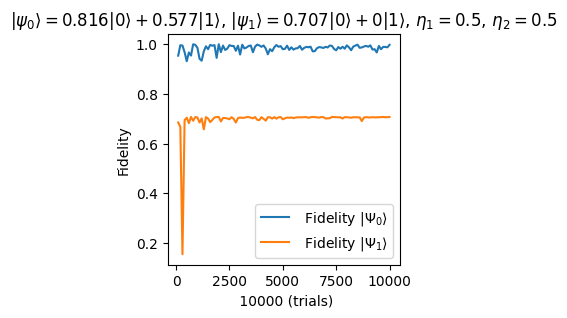

Error Coverged to:  , [0.9901645791291578, 0.7061573815663769]


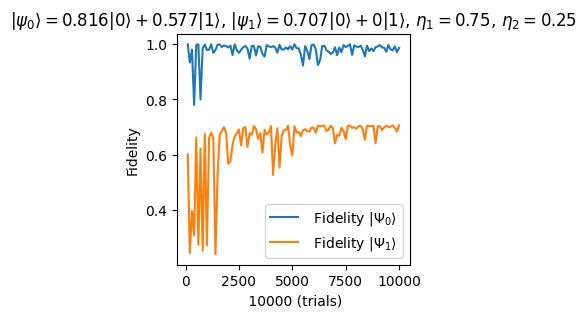

Error Coverged to:  , [0.99801394139633, 0.6606177882017217]


/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/4215831646.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  sol2 = (-b+np.sqrt(d))/(2*a)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/598383882.py:12: RuntimeWarning: invalid value encountered in scalar divide
  b0,b1 = (abs(z_b)/(np.sqrt(1+abs(z_b)**2))), (1/(np.sqrt(1+abs(z_b)**2)))


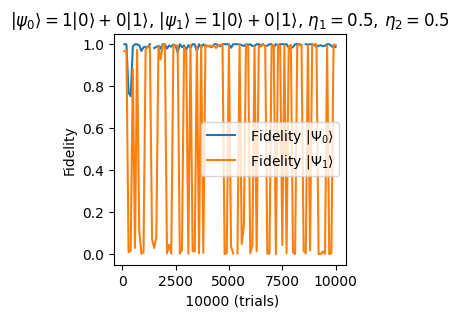

Error Coverged to:  , [0.9999795004253644, 0.0010000045000198693]


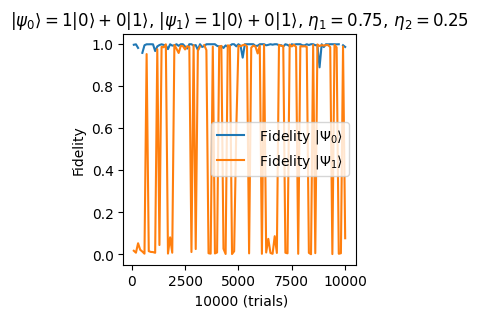

Error Coverged to:  , [0.9999963750305869, 0.004123064394434653]


In [184]:
#prev version..dont touch
c0 = [0,1,1,0]
c1 = [.707,.707,0,1]
c2 = [-.707,.707,0,1]
c3 = [-1,0,.707,.707]
c4 = [(2**.5)/(3**.5),1/(3**.5),.707,.707]         
c5 = [1,0,1,0]   # same states     

c_l = [c0,c1,c2,c3,c4,c5]
for c in c_l : 
    Plotting(c=c)
    # Plotting(c=c, p= [.75,.25])

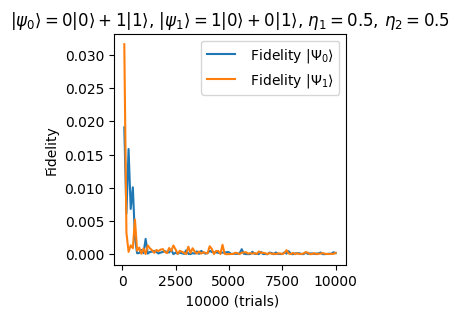

Error Coverged to:  , [0.00013524096768831274, 0.00010224654541627249]


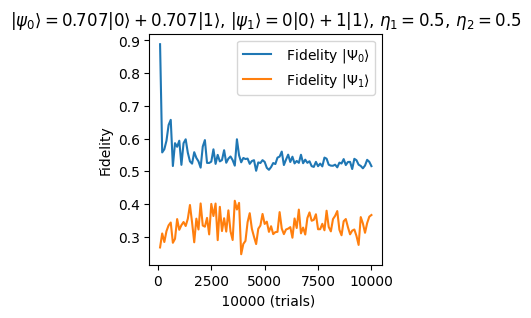

Error Coverged to:  , [0.5377796588655502, 0.3801290616989985]


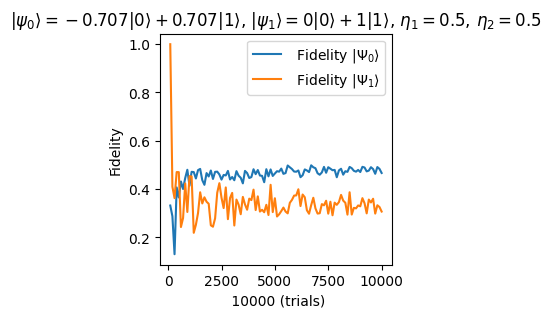

Error Coverged to:  , [0.49286247926516014, 0.33458810372977565]


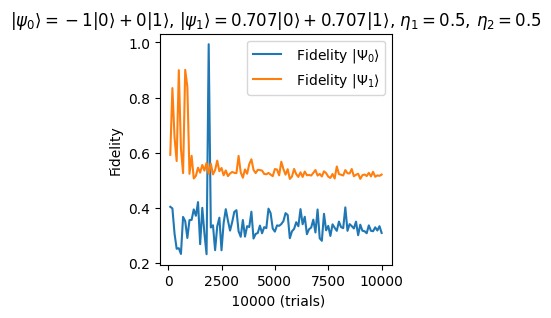

Error Coverged to:  , [0.32659766592907824, 0.516254014933769]


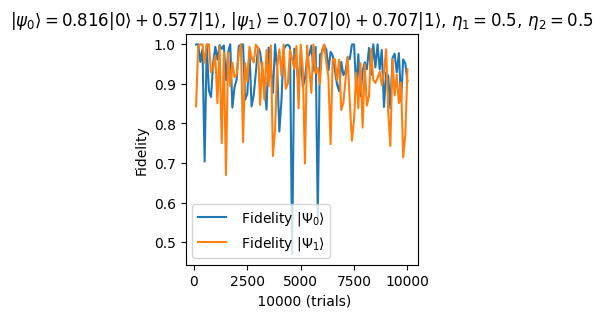

Error Coverged to:  , [0.9874107109072536, 0.9355979358207361]


/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/4215831646.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  sol1 = (-b-np.sqrt(d))/(2*a)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/4215831646.py:5: RuntimeWarning: invalid value encountered in scalar divide
  sol2 = (-b+np.sqrt(d))/(2*a)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/552907767.py:11: RuntimeWarning: invalid value encountered in scalar divide
  a0,a1 = (abs(z_a)/(np.sqrt(1+abs(z_a)**2))), (1/(np.sqrt(1+abs(z_a)**2)))
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/4215831646.py:4: RuntimeWarning: invalid value encountered in scalar divide
  sol1 = (-b-np.sqrt(d))/(2*a)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/4215831646.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  sol2 = (-b+np.sqrt(d))/(2*a)
/var/folders/z5/8__h5b611fz3d61c954t7_540000gp/T/ipykernel_66549/552907767.py:12: RuntimeWarn

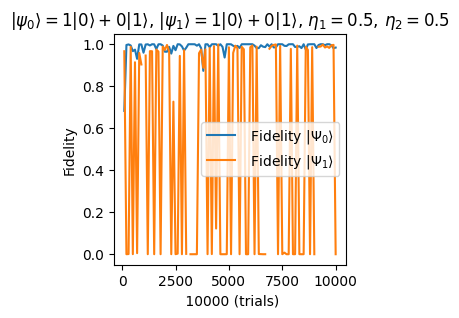

Error Coverged to:  , [0.9928363514097409, 0.9916166606510413]


In [299]:
#2
c0 = [0,1,1,0]
c1 = [.707,.707,0,1]
c2 = [-.707,.707,0,1]
c3 = [-1,0,.707,.707]
c4 = [(2**.5)/(3**.5),1/(3**.5),.707,.707]         
c5 = [1,0,1,0]   # same states   

c_l = [c0,c1,c2,c3,c4,c5]
for c in c_l : 
    Plotting(c=c)